# Importing Libraries

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import join

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

In [ ]:
#mounting google drive to access files

from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "/content/gdrive/My Drive/ETH_Price_Prediction"

Mounted at /content/gdrive


# Tensor Model

Setting model configurations. Our model uses one LSTM layer as it produces the best result. lock back is set to 5 days and the data is splitted in 80%/20% train and test.

In [426]:
look_back = 24*5
lstm_layers = 256
epochs=50
batch_size=128
train_test_split = 0.80

The dataset that we created in the last notebook is called here. The data is then scaled and the types are set to float32

In [88]:
df = pd.read_excel(join(drive_path,f'sentiment_analysis_dataset.xlsx'))

In [427]:
df1 = df.copy()
dateTime_col = df1[['DateTime']].copy()
df1 = df1.drop("DateTime", axis=1)

In [428]:
dataset = df1.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(df1.columns)

This section creates windows for LSTM layers. windows' dimensions are (Lock_back, num_features)

In [429]:
pred_col = df1.columns.get_loc('Close')

def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)

Splitting dataset into train and test and creating windows

In [430]:
train_set, test_set = np.split(dataset, [int(train_test_split *len(dataset))])

x_train, y_train = create_dataset(train_set, pred_col, look_back=look_back)
x_test, y_test = create_dataset(test_set, pred_col, look_back=look_back)

x_train = np.reshape(x_train, (x_train.shape[0], look_back, num_of_features))
x_test = np.reshape(x_test, (x_test.shape[0],look_back, num_of_features))

In [431]:
print('Number of features', num_of_features)
print('Training dataset length ', len(train_set))
print('Testing dataset length ', len(test_set))

Number of features 21
Training dataset length  2380
Testing dataset length  596


The code below creates the model. It has LSTM layer and a Dense layer. The Dense layer serves the purpose of generating a single number as the price prediction. It also uses Adam optimizer and mean_squared_error to calculate loss

In [432]:
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(x_train, y_train,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/50
13/13 [==============================] - 3s 71ms/step - loss: 0.0592 - val_loss: 0.0988
Epoch 2/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0854 - val_loss: 0.0172
Epoch 3/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 4/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/50
13/13 [==============================] - 0s 20ms/step - loss: 5.9851e-04 - val_loss: 6.3124e-04
Epoch 7/50
13/13 [==============================] - 0s 19ms/step - loss: 6.2985e-04 - val_loss: 6.0160e-04
Epoch 8/50
13/13 [==============================] - 0s 20ms/step - loss: 6.1588e-04 - val_loss: 5.2878e-04
Epoch 9/50
13/13 [==============================] - 0s 20ms/step - loss: 4.8702e-04 - val_loss: 5.3482e-04
Epoch 10/50
13/13 [==============================] - 0s 20ms/step - loss: 4.8

Validation and Training losses are plotted against each other. As it can be seen, the model starts from a high loss at first few epochs; So the righ plot
shows the loss after 20 epochs to so the minor changes can be visualized.

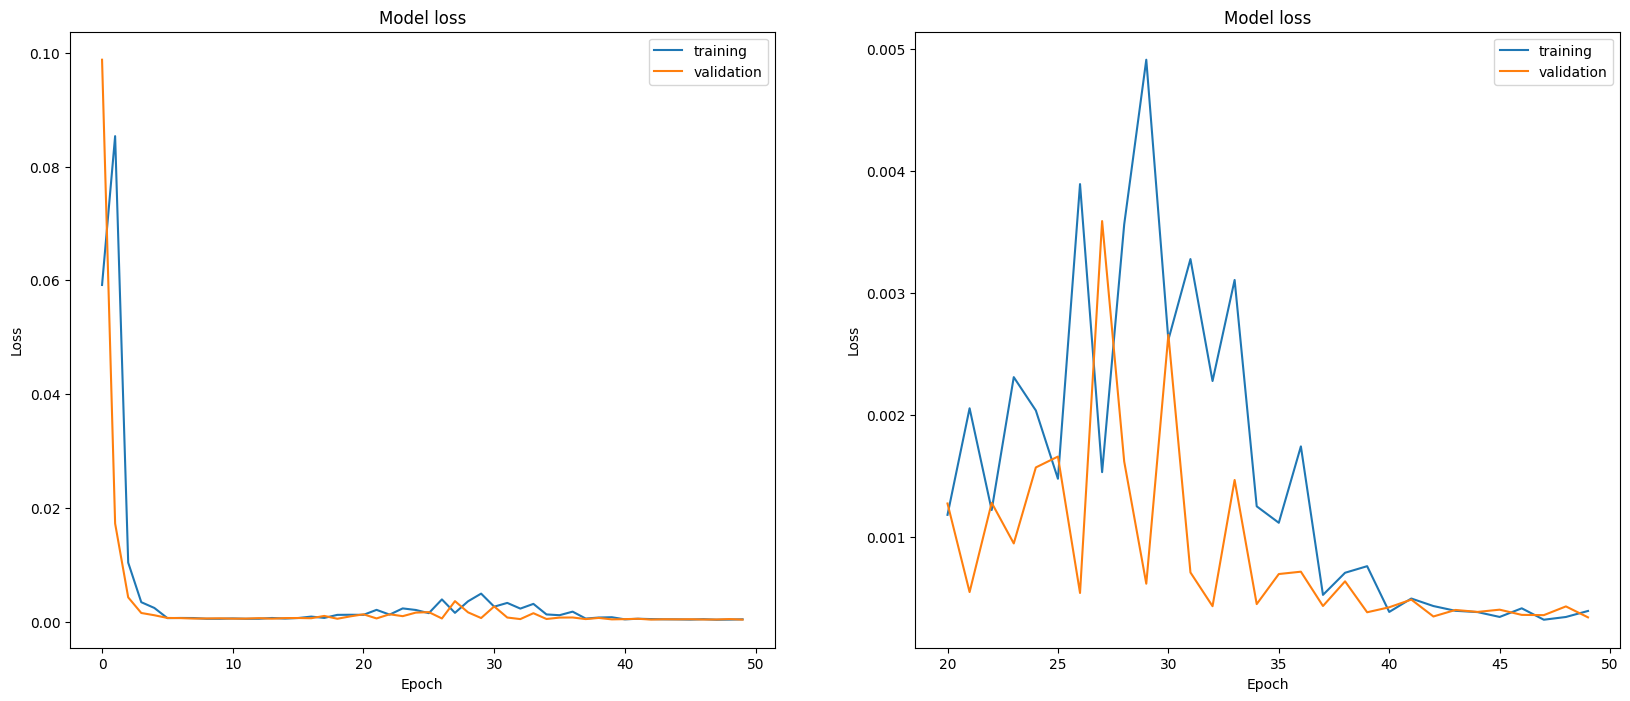

In [433]:
figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

loss = history.history['loss']
val_loss = history.history['val_loss']

axis[0].plot(loss)
axis[0].plot(val_loss)
axis[0].set_title('Model loss')
axis[0].set_ylabel('Loss')
axis[0].set_xlabel('Epoch')
axis[0].legend(['training', 'validation'], loc='upper right')

axis[1].plot(np.arange(20, len(loss)), loss[20:])
axis[1].plot(np.arange(20, len(val_loss)), val_loss[20:])
axis[1].set_title('Model loss')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend(['training', 'validation'], loc='upper right')

plt.show()

Saving the model for later use

In [439]:
model.save(join(drive_path,f'models/model_{look_back}_{lstm_layers}.h5'))

In [267]:
model = load_model(join(drive_path,f'models/model_72_256.h5'))

In [434]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

train_RMSE = mean_squared_error(y_train, trainPredict, squared=False)
test_RMSE = mean_squared_error(y_test, testPredict, squared=False)

train_MAE = mean_absolute_error(y_train, trainPredict)
test_MAE = mean_absolute_error(y_test, testPredict)

15/15 [==============================] - 0s 4ms/step


Inversing the price scaling to plot the data

In [435]:
# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict_scaled = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict_scaled = scaler.inverse_transform(testPredict_extended)[:,pred_col]

In [436]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_scaled)+look_back, pred_col] = trainPredict_scaled

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_scaled)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict_scaled

# contruct pandas dataframe for plotting
actual_df = pd.DataFrame(scaler.inverse_transform(dataset)[:,pred_col],columns=['Actual'])
train_df = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
test_df = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
result_df = pd.concat([actual_df, train_df, test_df, dateTime_col], axis=1, sort=False)
result_df.set_index('DateTime',inplace=True)

Text(0, 0.5, 'ETH Price')

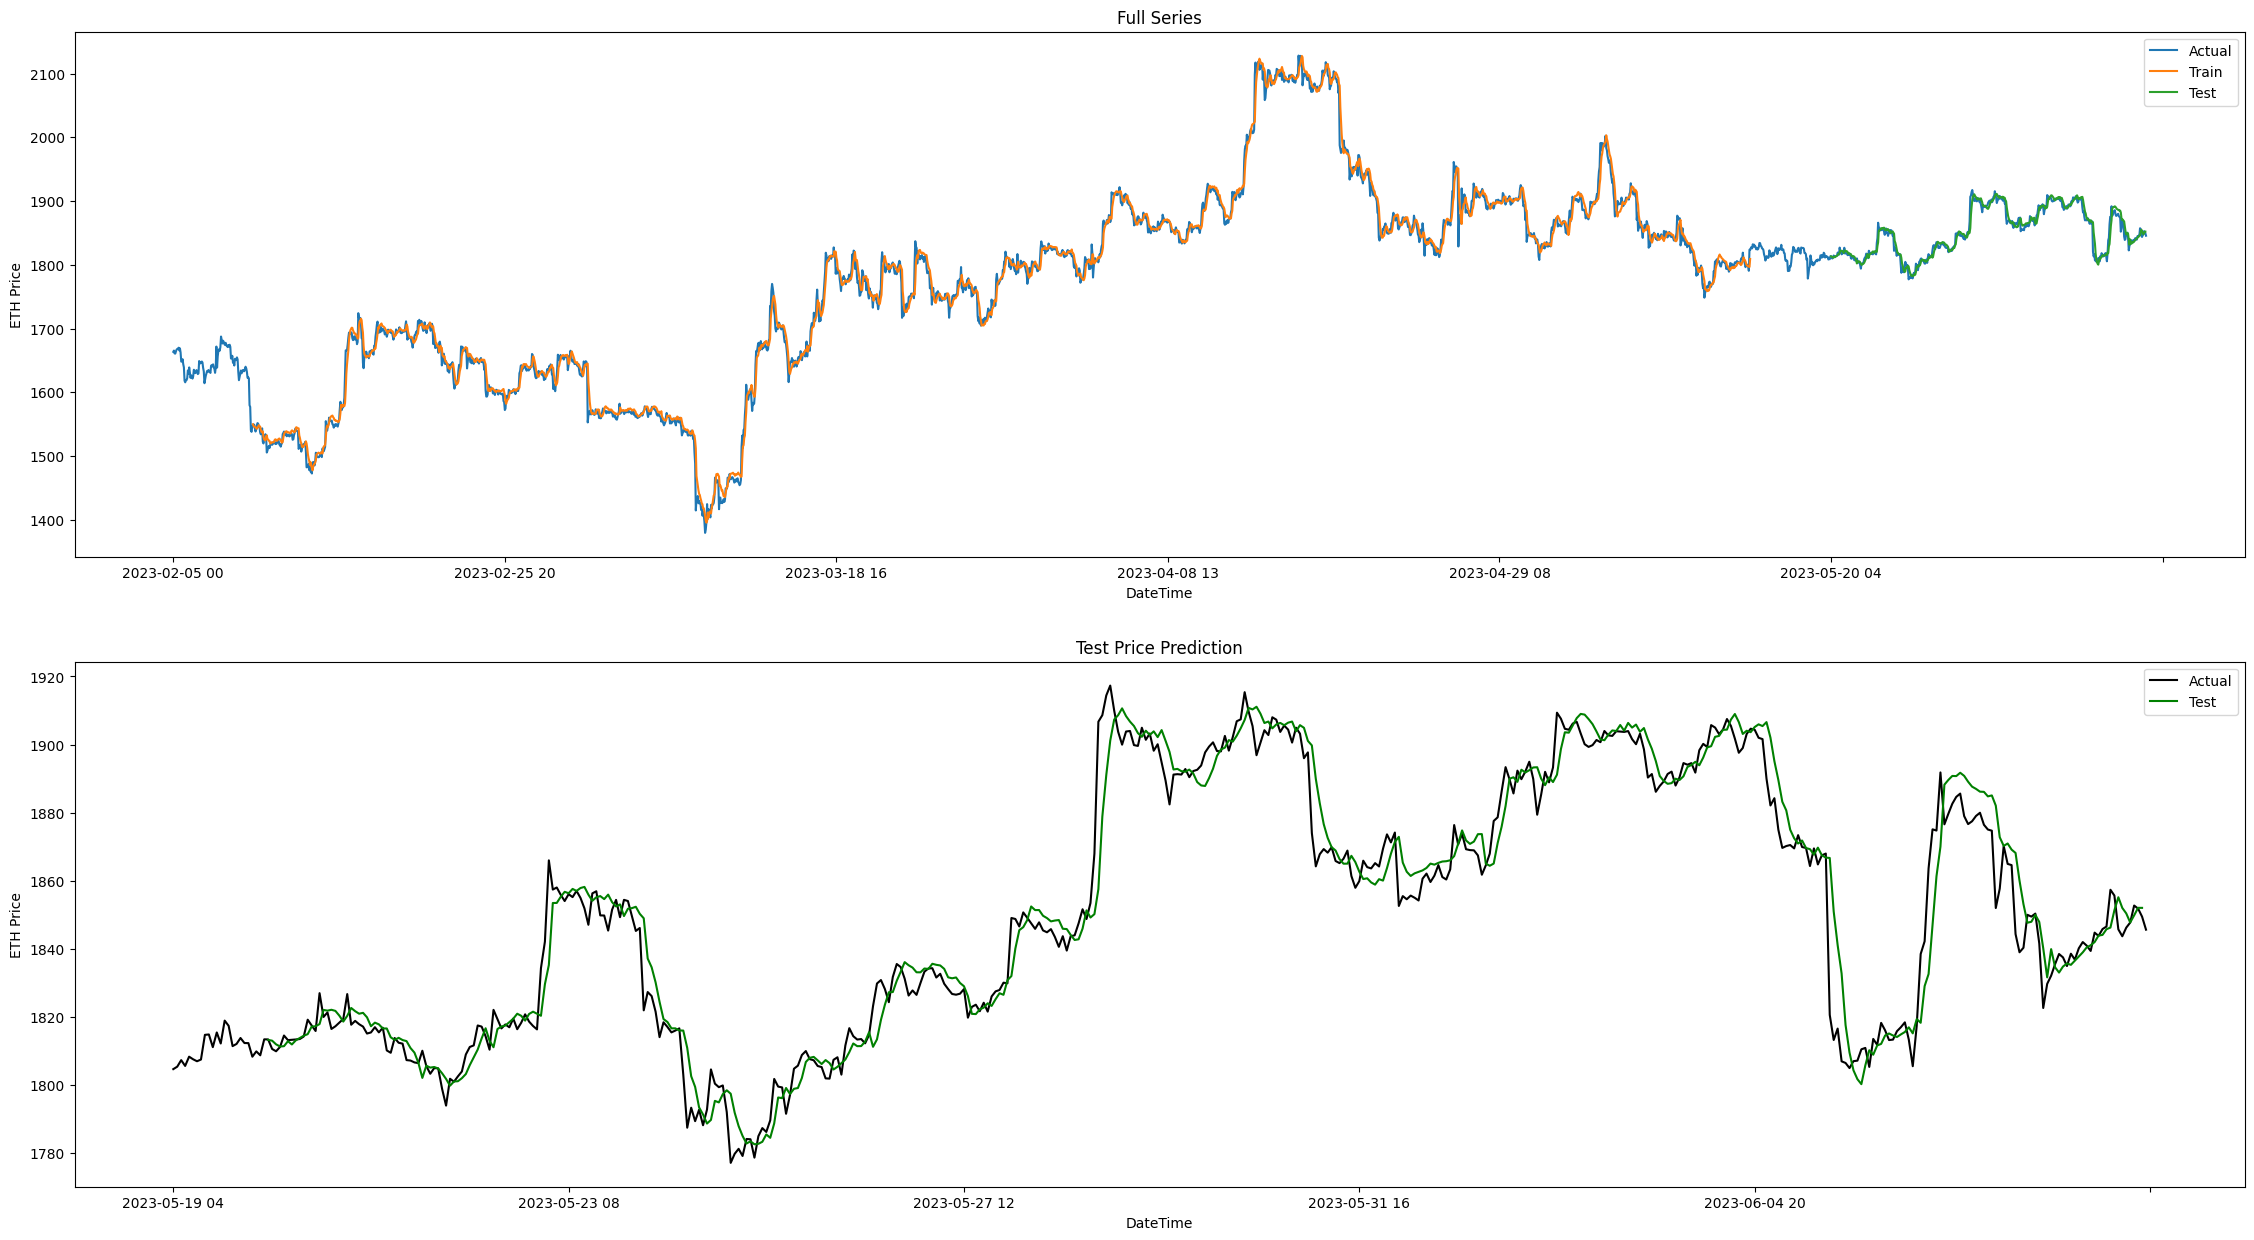

In [437]:
figure, axis = plt.subplots(2, 1, figsize=(28,15))

result_df.plot(ax=axis[0])
axis[0].set_title('Full Series')
axis[0].set_ylabel('ETH Price')

result_df.drop(["Train"], axis=1).tail(500).plot(
    ax=axis[1], color=['black','g'])
axis[1].set_title('Test Price Prediction')
axis[1].set_ylabel('ETH Price')

In [438]:
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(df1.columns))


print('-' * 50)
print('Train Score: %.5f RMSE' % (train_RMSE))
print('Test Score: %.5f RMSE' % (test_RMSE))

print('-' * 50)
print('Train Score: %.5f MAE' % (train_MAE))
print('Test Score: %.5f MAE' % (test_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

look_back days: 5.0
lstm_layers: 256
epochs: 50
batch_size: 128
dataset features ['Close', 'High', 'Low', 'Open', 'Volume', 'Change%', 'Range%', '24h_change%', 'Likes_T', 'Views_T', 'Follower_T', 'Total_T', 'Neutral_T', 'Negetive_T', 'Positive_T', 'Score_R', 'Upvote_R', 'Total_R', 'Neutral_R', 'Negetive_R', 'Positive_R']
--------------------------------------------------
Train Score: 0.01723 RMSE
Test Score: 0.01122 RMSE
--------------------------------------------------
Train Score: 0.01133 MAE
Test Score: 0.00732 MAE
--------------------------------------------------
Model summary:
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 256)               284672    
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                        